# Modelagem

In [1]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_halving_search_cv # Necessário para importar
from sklearn.model_selection import HalvingRandomSearchCV, KFold
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import uniform, randint # Para a distribuição de parâmetros
from sklearn.model_selection import GroupKFold

2025-10-08 19:31:06.708570: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-08 19:31:06.708862: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-08 19:31:06.747594: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-08 19:31:07.730576: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [2]:
df = pd.read_csv('training_b_df.csv').drop(columns=['index'])

In [3]:
X_train = df.drop(columns=['r'])
y_train = df['r']

In [4]:
X_train

,l_2,l_3,l_4,l_5,l_6,l_7,l_8,l_9,l_10,l_11,...,l_502,l_503,l_504,l_505,l_506,l_507,l_508,l_509,l_510,l_511
0,0.000172,0.000066,0.000078,0.000069,0.000063,0.000021,0.000053,0.000031,0.000043,0.000060,...,6.490171e-10,6.058483e-10,6.123373e-10,5.492230e-10,4.987756e-10,4.996063e-10,4.873860e-10,4.858634e-10,3.759005e-10,4.054609e-10
1,0.000058,0.000068,0.000118,0.000045,0.000045,0.000043,0.000063,0.000035,0.000042,0.000061,...,6.590990e-10,5.957533e-10,5.382490e-10,5.511306e-10,4.965663e-10,4.848698e-10,4.638441e-10,4.146040e-10,3.850935e-10,3.658829e-10
2,0.000066,0.000086,0.000129,0.000044,0.000056,0.000038,0.000041,0.000059,0.000060,0.000048,...,6.345819e-10,6.044535e-10,5.756162e-10,5.306156e-10,4.744517e-10,4.625054e-10,4.354919e-10,3.960931e-10,3.977156e-10,3.608611e-10
3,0.000140,0.000167,0.000060,0.000070,0.000064,0.000030,0.000018,0.000049,0.000025,0.000042,...,6.901658e-10,6.067260e-10,5.923192e-10,5.206132e-10,5.064276e-10,4.546328e-10,4.771503e-10,4.041781e-10,3.925857e-10,3.493796e-10
4,0.000025,0.000066,0.000041,0.000060,0.000052,0.000034,0.000046,0.000031,0.000035,0.000084,...,7.062580e-10,6.144698e-10,5.878574e-10,5.581525e-10,5.349131e-10,4.615936e-10,4.710612e-10,4.277015e-10,3.812178e-10,3.678812e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.000017,0.000209,0.000385,0.000079,0.000089,0.000040,0.000053,0.000055,0.000056,0.000124,...,6.567375e-10,5.516829e-10,5.934444e-10,5.169918e-10,5.210142e-10,4.470891e-10,4.619118e-10,3.933742e-10,3.561920e-10,3.397018e-10
9996,0.000021,0.000200,0.000087,0.000099,0.000158,0.000047,0.000015,0.000058,0.000137,0.000072,...,5.976479e-10,5.594487e-10,5.265735e-10,4.667441e-10,4.792801e-10,4.221269e-10,3.972213e-10,3.605560e-10,3.874225e-10,3.352761e-10
9997,0.000244,0.000103,0.000202,0.000152,0.000073,0.000035,0.000057,0.000036,0.000052,0.000085,...,6.693528e-10,5.235341e-10,6.281461e-10,5.356119e-10,5.341638e-10,4.507673e-10,4.504032e-10,4.218950e-10,4.454599e-10,3.516340e-10
9998,0.000029,0.000242,0.000166,0.000151,0.000074,0.000058,0.000049,0.000089,0.000043,0.000053,...,6.437310e-10,5.865421e-10,5.865462e-10,5.099055e-10,5.082683e-10,4.383359e-10,4.465953e-10,3.948185e-10,3.890945e-10,3.387430e-10


In [5]:
y_train

0       0.002872
1       0.002872
2       0.002872
3       0.002872
4       0.002872
          ...   
9995    0.014936
9996    0.014936
9997    0.014936
9998    0.014936
9999    0.014936
Name: r, Length: 10000, dtype: float64

In [6]:
def criar_modelo_otimizado(neurons=64, learning_rate=0.001):
    """Cria e compila um modelo de Rede Neural com hiperparâmetros ajustáveis."""
    
    # Define o otimizador com a taxa de aprendizado testada
    optimizer = Adam(learning_rate=learning_rate)
    
    model = Sequential([
        # Primeira Camada
        Dense(neurons, activation='relu', input_shape=(510,)), 
        
        # Segunda Camada (fixada)
        Dense(32, activation='relu'), 
        
        # Camada de Saída
        Dense(1, activation='linear')
    ])
    
    # Compilação
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [7]:
# 1. Distribuição de Parâmetros a serem testados (ranges ao invés de listas fixas)
param_distributions = {
    # Neurônios: número inteiro aleatório entre 32 e 256
    'model__neurons': randint(low=32, high=256), 
    
    # Taxa de Aprendizado: valor contínuo aleatório em escala logarítmica
    # Ex: entre 1e-4 e 1e-2 (0.0001 e 0.01)
    'model__learning_rate': uniform(loc=0.0001, scale=0.0099), 
    
    # Batch Size: valores discretos
    'batch_size': [16, 32, 64],
    
    # Epochs: valores discretos (o HRS vai descartar os piores cedo)
    'epochs': [5, 10, 20] 
}

# 2. Configurar o KerasRegressor
nn_model = KerasRegressor(
    model=criar_modelo_otimizado, 
    verbose=0 
)

## Atenção

- Ao juntar as features com o target, foram colocadas 10 simulações associadas ao mesmo target. 

- Ao usar a validação cruzada é preciso ter certeza de que as linhas associadas a um dado valor do target, caiam tanto na validação quanto no treino, evitando assim o vazamento do target. 

- Para isso utiliza-se o parâmetro `cv=gkf` no HalvingRandomSearch abaixo.

- A variável gkf usa a classe GroupKFold para levar em consideração a observação acima e evitar o vazamento do target.

In [8]:
groups = y_train.to_numpy().ravel() 

In [9]:
groups

array([0.002872, 0.002872, 0.002872, ..., 0.014936, 0.014936, 0.014936],
      shape=(10000,))

Abaixo, verifica-se se realmente não há vazamento de target usando-se o GrupoKFold

In [10]:
# Inicialize o GroupKFold
gkf = GroupKFold(n_splits=5) 

# Itere sobre os splits (apenas a primeira dobra é suficiente para checar)
for fold, (train_index, val_index) in enumerate(gkf.split(X_train, y_train, groups=groups)):
    
    if fold == 0: # Checar apenas o primeiro fold
        
        # 1. Obter os valores de 'r' (originais, não escalados) para Treino e Validação
        r_train_fold = y_train[train_index].to_numpy().ravel()
        r_val_fold = y_train[val_index].to_numpy().ravel()
        
        # 2. Encontrar os valores ÚNICOS de 'r' em cada conjunto
        r_unique_train = set(r_train_fold)
        r_unique_val = set(r_val_fold)
        
        # 3. Encontrar a Interseção (os valores vazados)
        vazamentos = r_unique_train.intersection(r_unique_val)
        
        print(f"--- Checagem do Fold {fold + 1} ---")
        print(f"Total de valores únicos de 'r' no Treino: {len(r_unique_train)}")
        print(f"Total de valores únicos de 'r' na Validação: {len(r_unique_val)}")
        print(f"Valores de 'r' vazando (Interseção): {len(vazamentos)}")
        
        if len(vazamentos) == 0:
            print("✅ GroupKFold está funcionando corretamente: Nenhuma intersecção de valores de 'r'.")
        else:
            print(f"❌ ERRO GRAVE: {len(vazamentos)} valores de 'r' estão vazando! O GroupKFold falhou na divisão dos grupos.")
            print(f"Valores vazados (Primeiros 5): {list(vazamentos)[:5]}")
            
        break # Parar após o primeiro fold

--- Checagem do Fold 1 ---
Total de valores únicos de 'r' no Treino: 800
Total de valores únicos de 'r' na Validação: 200
Valores de 'r' vazando (Interseção): 0
✅ GroupKFold está funcionando corretamente: Nenhuma intersecção de valores de 'r'.


In [11]:
# factor=2: Descarta metade dos candidatos a cada iteração.
# candidates: O número total de combinações que serão testadas na 1ª rodada (a maior).
hrs = HalvingRandomSearchCV(
    estimator=nn_model, 
    param_distributions=param_distributions, 
    factor=2, 
    n_candidates=50,
    scoring='r2', 
    random_state=42,
    cv=gkf, 
    verbose=2,
    n_jobs=-1 
)

print("Iniciando Halving Random Search (Testando as melhores combinações eficientemente)...")

# 4. Executar a busca
# O HRS executa a busca e o retreinamento (refit=True)
hrs_result = hrs.fit(X_train, y_train, groups=groups)

Iniciando Halving Random Search (Testando as melhores combinações eficientemente)...
n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 10
min_resources_: 10
max_resources_: 10000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 50
n_resources: 10
Fitting 5 folds for each of 50 candidates, totalling 250 fits


2025-10-08 19:31:10.036811: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-08 19:31:10.037674: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-08 19:31:10.043000: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-08 19:31:10.043531: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-08 19:31:10.065504: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your

[CV] END batch_size=64, epochs=5, model__learning_rate=0.0019160044196750217, model__neurons=103; total time=   1.7s
[CV] END batch_size=64, epochs=5, model__learning_rate=0.0019160044196750217, model__neurons=103; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__learning_rate=0.0019160044196750217, model__neurons=103; total time=   1.7s
[CV] END batch_size=64, epochs=5, model__learning_rate=0.0019160044196750217, model__neurons=103; total time=   1.9s
[CV] END batch_size=16, epochs=5, model__learning_rate=0.0016445845403801217, model__neurons=242; total time=   1.6s
[CV] END batch_size=16, epochs=5, model__learning_rate=0.0016445845403801217, model__neurons=242; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__learning_rate=0.0016445845403801217, model__neurons=242; total time=   1.7s
[CV] END batch_size=64, epochs=5, model__learning_rate=0.0019160044196750217, model__neurons=103; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=5, model__learning_rate=0.0016445845403801217, model__neurons=242; total time=   1.4s
[CV] END batch_size=16, epochs=5, model__learning_rate=0.0016445845403801217, model__neurons=242; total time=   1.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=10, model__learning_rate=0.0006584746323682926, model__neurons=119; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__learning_rate=0.004646564030462086, model__neurons=148; total time=   2.1s
[CV] END batch_size=64, epochs=20, model__learning_rate=0.004646564030462086, model__neurons=148; total time=   2.2s
[CV] END batch_size=64, epochs=20, model__learning_rate=0.004646564030462086, model__neurons=148; total time=   2.1s
[CV] END batch_size=64, epochs=20, model__learning_rate=0.004646564030462086, model__neurons=148; total time=   2.1s
[CV] END batch_size=64, epochs=20, model__learning_rate=0.004646564030462086, model__neurons=148; total time=   2.1s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=64, epochs=10, model__learning_rate=0.0006584746323682926, model__neurons=119; total time=   1.6s
[CV] END batch_size=64, epochs=10, model__learning_rate=0.0006584746323682926, model__neurons=119; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=10, model__learning_rate=0.0006584746323682926, model__neurons=119; total time=   1.6s
[CV] END batch_size=64, epochs=10, model__learning_rate=0.0006584746323682926, model__neurons=119; total time=   1.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__learning_rate=0.00010770978182604186, model__neurons=219; total time=   1.7s
[CV] END batch_size=32, epochs=10, model__learning_rate=0.00010770978182604186, model__neurons=219; total time=   1.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__learning_rate=0.00010770978182604186, model__neurons=219; total time=   1.7s
[CV] END batch_size=32, epochs=10, model__learning_rate=0.00010770978182604186, model__neurons=219; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__learning_rate=0.0031119982052994237, model__neurons=53; total time=   1.5s
[CV] END batch_size=32, epochs=10, model__learning_rate=0.00010770978182604186, model__neurons=219; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__learning_rate=0.0031119982052994237, model__neurons=53; total time=   1.4s
[CV] END batch_size=16, epochs=5, model__learning_rate=0.0031119982052994237, model__neurons=53; total time=   1.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__learning_rate=0.0031119982052994237, model__neurons=53; total time=   1.5s
[CV] END batch_size=16, epochs=5, model__learning_rate=0.0031119982052994237, model__neurons=53; total time=   1.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__learning_rate=0.002983168487960615, model__neurons=90; total time=   1.4s
[CV] END batch_size=16, epochs=5, model__learning_rate=0.002983168487960615, model__neurons=90; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__learning_rate=0.002983168487960615, model__neurons=90; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__learning_rate=0.002983168487960615, model__neurons=90; total time=   1.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__learning_rate=0.002983168487960615, model__neurons=90; total time=   1.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=10, model__learning_rate=0.0005619900658147928, model__neurons=219; total time=   1.8s
[CV] END batch_size=64, epochs=10, model__learning_rate=0.0005619900658147928, model__neurons=219; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=10, model__learning_rate=0.0005619900658147928, model__neurons=219; total time=   1.9s
[CV] END batch_size=64, epochs=10, model__learning_rate=0.0005619900658147928, model__neurons=219; total time=   1.8s
[CV] END batch_size=64, epochs=10, model__learning_rate=0.0005619900658147928, model__neurons=219; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=64, epochs=10, model__learning_rate=0.000997003701874926, model__neurons=221; total time=   2.0s
[CV] END batch_size=64, epochs=10, model__learning_rate=0.000997003701874926, model__neurons=221; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=10, model__learning_rate=0.000997003701874926, model__neurons=221; total time=   1.9s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=10, model__learning_rate=0.000997003701874926, model__neurons=221; total time=   1.8s
[CV] END batch_size=64, epochs=10, model__learning_rate=0.000997003701874926, model__neurons=221; total time=   1.9s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__learning_rate=0.009833985769487203, model__neurons=162; total time=   2.4s
[CV] END batch_size=64, epochs=20, model__learning_rate=0.009833985769487203, model__neurons=162; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__learning_rate=0.009833985769487203, model__neurons=162; total time=   2.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__learning_rate=0.009833985769487203, model__neurons=162; total time=   2.2s
[CV] END batch_size=64, epochs=20, model__learning_rate=0.009833985769487203, model__neurons=162; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__learning_rate=0.00683504463201902, model__neurons=104; total time=   2.2s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__learning_rate=0.00683504463201902, model__neurons=104; total time=   2.2s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.00683504463201902, model__neurons=104; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=10, model__learning_rate=0.009493966818808, model__neurons=91; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__learning_rate=0.00683504463201902, model__neurons=104; total time=   2.3s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.00683504463201902, model__neurons=104; total time=   2.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=10, model__learning_rate=0.009493966818808, model__neurons=91; total time=   1.8s
[CV] END batch_size=64, epochs=10, model__learning_rate=0.009493966818808, model__neurons=91; total time=   1.7s
[CV] END batch_size=64, epochs=10, model__learning_rate=0.009493966818808, model__neurons=91; total time=   2.0s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=64, epochs=10, model__learning_rate=0.009493966818808, model__neurons=91; total time=   1.8s
[CV] END batch_size=32, epochs=10, model__learning_rate=0.00391562337514517, model__neurons=121; total time=   1.9s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__learning_rate=0.00391562337514517, model__neurons=121; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__learning_rate=0.00391562337514517, model__neurons=121; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__learning_rate=0.00391562337514517, model__neurons=121; total time=   2.0s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=10, model__learning_rate=0.006873906962470354, model__neurons=142; total time=   2.0s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=10, model__learning_rate=0.006873906962470354, model__neurons=142; total time=   2.1s
[CV] END batch_size=32, epochs=10, model__learning_rate=0.00391562337514517, model__neurons=121; total time=   2.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=10, model__learning_rate=0.006873906962470354, model__neurons=142; total time=   2.3s
[CV] END batch_size=16, epochs=10, model__learning_rate=0.006873906962470354, model__neurons=142; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=10, model__learning_rate=0.006873906962470354, model__neurons=142; total time=   2.1s
[CV] END batch_size=64, epochs=5, model__learning_rate=0.008348629626188027, model__neurons=66; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__learning_rate=0.008348629626188027, model__neurons=66; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__learning_rate=0.008348629626188027, model__neurons=66; total time=   1.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__learning_rate=0.008348629626188027, model__neurons=66; total time=   1.5s
[CV] END batch_size=64, epochs=5, model__learning_rate=0.008348629626188027, model__neurons=66; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=5, model__learning_rate=0.0026619218178401674, model__neurons=135; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=5, model__learning_rate=0.0026619218178401674, model__neurons=135; total time=   1.5s
[CV] END batch_size=32, epochs=5, model__learning_rate=0.0026619218178401674, model__neurons=135; total time=   1.6s
[CV] END batch_size=32, epochs=5, model__learning_rate=0.0026619218178401674, model__neurons=135; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=32, epochs=5, model__learning_rate=0.0026619218178401674, model__neurons=135; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__learning_rate=0.005248673409660328, model__neurons=137; total time=   1.9s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__learning_rate=0.005248673409660328, model__neurons=137; total time=   1.9s
[CV] END batch_size=32, epochs=10, model__learning_rate=0.005248673409660328, model__neurons=137; total time=   2.1s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__learning_rate=0.005248673409660328, model__neurons=137; total time=   1.7s
[CV] END batch_size=32, epochs=5, model__learning_rate=0.00969888781486913, model__neurons=249; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=5, model__learning_rate=0.00969888781486913, model__neurons=249; total time=   1.6s
[CV] END batch_size=32, epochs=5, model__learning_rate=0.00969888781486913, model__neurons=249; total time=   1.4s
[CV] END batch_size=32, epochs=10, model__learning_rate=0.005248673409660328, model__neurons=137; total time=   1.9s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=32, epochs=5, model__learning_rate=0.00969888781486913, model__neurons=249; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=5, model__learning_rate=0.00969888781486913, model__neurons=249; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__learning_rate=0.008958790769233723, model__neurons=45; total time=   1.6s
[CV] END batch_size=32, epochs=10, model__learning_rate=0.008958790769233723, model__neurons=45; total time=   1.6s
[CV] END batch_size=32, epochs=10, model__learning_rate=0.008958790769233723, model__neurons=45; total time=   1.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=32, epochs=10, model__learning_rate=0.008958790769233723, model__neurons=45; total time=   1.6s
[CV] END batch_size=32, epochs=10, model__learning_rate=0.008958790769233723, model__neurons=45; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__learning_rate=0.0009760757703140031, model__neurons=246; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__learning_rate=0.0009760757703140031, model__neurons=246; total time=   2.4s
[CV] END batch_size=64, epochs=20, model__learning_rate=0.0009760757703140031, model__neurons=246; total time=   2.2s
[CV] END batch_size=16, epochs=10, model__learning_rate=0.003320770274556317, model__neurons=239; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=10, model__learning_rate=0.003320770274556317, model__neurons=239; total time=   1.6s
[CV] END batch_size=64, epochs=20, model__learning_rate=0.0009760757703140031, model__neurons=246; total time=   2.2s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=10, model__learning_rate=0.003320770274556317, model__neurons=239; total time=   1.7s
[CV] END batch_size=64, epochs=20, model__learning_rate=0.0009760757703140031, model__neurons=246; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=10, model__learning_rate=0.003320770274556317, model__neurons=239; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=10, model__learning_rate=0.003320770274556317, model__neurons=239; total time=   1.7s
[CV] END batch_size=16, epochs=10, model__learning_rate=0.0054429521106518905, model__neurons=55; total time=   1.6s
[CV] END batch_size=16, epochs=10, model__learning_rate=0.0054429521106518905, model__neurons=55; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=10, model__learning_rate=0.0054429521106518905, model__neurons=55; total time=   1.6s
[CV] END batch_size=32, epochs=5, model__learning_rate=0.0028812516459050695, model__neurons=155; total time=   1.3s
[CV] END batch_size=16, epochs=10, model__learning_rate=0.0054429521106518905, model__neurons=55; total time=   1.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=10, model__learning_rate=0.0054429521106518905, model__neurons=55; total time=   1.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=5, model__learning_rate=0.0028812516459050695, model__neurons=155; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=5, model__learning_rate=0.0028812516459050695, model__neurons=155; total time=   1.4s
[CV] END batch_size=32, epochs=5, model__learning_rate=0.0028812516459050695, model__neurons=155; total time=   1.3s
[CV] END batch_size=32, epochs=5, model__learning_rate=0.0028812516459050695, model__neurons=155; total time=   1.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=5, model__learning_rate=0.0030331077064704158, model__neurons=76; total time=   1.3s
[CV] END batch_size=16, epochs=5, model__learning_rate=0.0030331077064704158, model__neurons=76; total time=   1.4s
[CV] END batch_size=16, epochs=5, model__learning_rate=0.0030331077064704158, model__neurons=76; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=5, model__learning_rate=0.0030331077064704158, model__neurons=76; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__learning_rate=0.0030331077064704158, model__neurons=76; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__learning_rate=0.009870180672345122, model__neurons=119; total time=   1.3s
[CV] END batch_size=16, epochs=5, model__learning_rate=0.009870180672345122, model__neurons=119; total time=   1.4s
[CV] END batch_size=16, epochs=5, model__learning_rate=0.009870180672345122, model__neurons=119; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=5, model__learning_rate=0.009870180672345122, model__neurons=119; total time=   1.3s
[CV] END batch_size=16, epochs=5, model__learning_rate=0.009870180672345122, model__neurons=119; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__learning_rate=0.008173068141702858, model__neurons=112; total time=   2.2s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__learning_rate=0.008173068141702858, model__neurons=112; total time=   2.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__learning_rate=0.008173068141702858, model__neurons=112; total time=   2.6s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.008173068141702858, model__neurons=112; total time=   2.2s
[CV] END batch_size=64, epochs=20, model__learning_rate=0.007735576432190864, model__neurons=36; total time=   2.2s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=20, model__learning_rate=0.008173068141702858, model__neurons=112; total time=   2.4s
[CV] END batch_size=64, epochs=20, model__learning_rate=0.007735576432190864, model__neurons=36; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__learning_rate=0.007735576432190864, model__neurons=36; total time=   2.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__learning_rate=0.007735576432190864, model__neurons=36; total time=   2.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__learning_rate=0.007735576432190864, model__neurons=36; total time=   2.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__learning_rate=0.006270651455592824, model__neurons=193; total time=   1.9s
[CV] END batch_size=32, epochs=20, model__learning_rate=0.006545662552469251, model__neurons=59; total time=   2.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=20, model__learning_rate=0.006545662552469251, model__neurons=59; total time=   2.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=20, model__learning_rate=0.006545662552469251, model__neurons=59; total time=   2.7s
[CV] END batch_size=32, epochs=20, model__learning_rate=0.006545662552469251, model__neurons=59; total time=   2.9s
[CV] END batch_size=32, epochs=20, model__learning_rate=0.006545662552469251, model__neurons=59; total time=   2.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=64, epochs=5, model__learning_rate=0.006270651455592824, model__neurons=193; total time=   1.9s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__learning_rate=0.006270651455592824, model__neurons=193; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__learning_rate=0.006270651455592824, model__neurons=193; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__learning_rate=0.006270651455592824, model__neurons=193; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__learning_rate=0.0031787249849850557, model__neurons=247; total time=   2.5s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.0031787249849850557, model__neurons=247; total time=   2.2s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.0031787249849850557, model__neurons=247; total time=   2.2s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.0031787249849850557, model__neurons=247; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=20, model__learning_rate=0.0031787249849850557, model__neurons=247; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__learning_rate=0.0059538480983064995, model__neurons=245; total time=   2.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__learning_rate=0.0059538480983064995, model__neurons=245; total time=   2.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__learning_rate=0.0059538480983064995, model__neurons=245; total time=   2.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__learning_rate=0.0059538480983064995, model__neurons=245; total time=   2.2s
[CV] END batch_size=64, epochs=20, model__learning_rate=0.0047749277591032984, model__neurons=132; total time=   2.2s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.0059538480983064995, model__neurons=245; total time=   2.3s
[CV] END batch_size=64, epochs=20, model__learning_rate=0.0047749277591032984, model__neurons=132; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=64, epochs=20, model__learning_rate=0.0047749277591032984, model__neurons=132; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__learning_rate=0.0047749277591032984, model__neurons=132; total time=   2.2s
[CV] END batch_size=64, epochs=10, model__learning_rate=0.008504246860234231, model__neurons=36; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__learning_rate=0.0047749277591032984, model__neurons=132; total time=   2.2s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=10, model__learning_rate=0.008504246860234231, model__neurons=36; total time=   1.7s
[CV] END batch_size=64, epochs=10, model__learning_rate=0.008504246860234231, model__neurons=36; total time=   1.7s
[CV] END batch_size=64, epochs=10, model__learning_rate=0.008504246860234231, model__neurons=36; total time=   1.7s
[CV] END batch_size=64, epochs=10, model__learning_rate=0.008504246860234231, model__neurons=36; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=32, epochs=20, model__learning_rate=0.007732575081550155, model__neurons=134; total time=   2.3s
[CV] END batch_size=64, epochs=5, model__learning_rate=0.007135562607889296, model__neurons=121; total time=   1.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__learning_rate=0.007135562607889296, model__neurons=121; total time=   1.3s
[CV] END batch_size=32, epochs=20, model__learning_rate=0.007732575081550155, model__neurons=134; total time=   2.2s
[CV] END batch_size=64, epochs=5, model__learning_rate=0.007135562607889296, model__neurons=121; total time=   1.3s
[CV] END batch_size=32, epochs=20, model__learning_rate=0.007732575081550155, model__neurons=134; total time=   2.2s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=32, epochs=20, model__learning_rate=0.007732575081550155, model__neurons=134; total time=   2.2s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=20, model__learning_rate=0.007732575081550155, model__neurons=134; total time=   2.2s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__learning_rate=0.007135562607889296, model__neurons=121; total time=   1.4s
[CV] END batch_size=64, epochs=5, model__learning_rate=0.007135562607889296, model__neurons=121; total time=   1.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=5, model__learning_rate=0.002097020103120422, model__neurons=127; total time=   1.4s
[CV] END batch_size=32, epochs=5, model__learning_rate=0.002097020103120422, model__neurons=127; total time=   1.4s
[CV] END batch_size=32, epochs=5, model__learning_rate=0.002097020103120422, model__neurons=127; total time=   1.4s
[CV] END batch_size=32, epochs=5, model__learning_rate=0.002097020103120422, model__neurons=127; total time=   1.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=32, epochs=5, model__learning_rate=0.002097020103120422, model__neurons=127; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__learning_rate=0.003212124212655634, model__neurons=127; total time=   1.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__learning_rate=0.003212124212655634, model__neurons=127; total time=   1.4s
[CV] END batch_size=64, epochs=5, model__learning_rate=0.003212124212655634, model__neurons=127; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=5, model__learning_rate=0.002567993068573862, model__neurons=174; total time=   1.3s
[CV] END batch_size=32, epochs=5, model__learning_rate=0.002567993068573862, model__neurons=174; total time=   1.3s
[CV] END batch_size=64, epochs=5, model__learning_rate=0.003212124212655634, model__neurons=127; total time=   1.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=64, epochs=5, model__learning_rate=0.003212124212655634, model__neurons=127; total time=   1.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=5, model__learning_rate=0.002567993068573862, model__neurons=174; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=5, model__learning_rate=0.002567993068573862, model__neurons=174; total time=   1.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=5, model__learning_rate=0.002567993068573862, model__neurons=174; total time=   1.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__learning_rate=0.0023651018383670625, model__neurons=191; total time=   1.5s
[CV] END batch_size=64, epochs=5, model__learning_rate=0.0023651018383670625, model__neurons=191; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__learning_rate=0.0023651018383670625, model__neurons=191; total time=   1.6s
[CV] END batch_size=64, epochs=5, model__learning_rate=0.0023651018383670625, model__neurons=191; total time=   1.5s
[CV] END batch_size=64, epochs=5, model__learning_rate=0.0023651018383670625, model__neurons=191; total time=   1.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=64, epochs=20, model__learning_rate=0.006978370837093076, model__neurons=59; total time=   2.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__learning_rate=0.006978370837093076, model__neurons=59; total time=   2.4s
[CV] END batch_size=32, epochs=10, model__learning_rate=0.008100391757687729, model__neurons=216; total time=   1.8s
[CV] END batch_size=64, epochs=20, model__learning_rate=0.006978370837093076, model__neurons=59; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=32, epochs=10, model__learning_rate=0.008100391757687729, model__neurons=216; total time=   1.8s
[CV] END batch_size=32, epochs=10, model__learning_rate=0.008100391757687729, model__neurons=216; total time=   1.9s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__learning_rate=0.006978370837093076, model__neurons=59; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__learning_rate=0.006978370837093076, model__neurons=59; total time=   2.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__learning_rate=0.008100391757687729, model__neurons=216; total time=   2.1s
[CV] END batch_size=32, epochs=10, model__learning_rate=0.008100391757687729, model__neurons=216; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=10, model__learning_rate=0.004619692247780812, model__neurons=139; total time=   1.9s
[CV] END batch_size=16, epochs=10, model__learning_rate=0.004619692247780812, model__neurons=139; total time=   1.9s
[CV] END batch_size=16, epochs=10, model__learning_rate=0.004619692247780812, model__neurons=139; total time=   1.9s
[CV] END batch_size=16, epochs=10, model__learning_rate=0.004619692247780812, model__neurons=139; total time=   2.1s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=10, model__learning_rate=0.004619692247780812, model__neurons=139; total time=   1.8s
[CV] END batch_size=32, epochs=10, model__learning_rate=0.005439488194964943, model__neurons=123; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__learning_rate=0.005439488194964943, model__neurons=123; total time=   1.9s
[CV] END batch_size=32, epochs=10, model__learning_rate=0.005439488194964943, model__neurons=123; total time=   2.1s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__learning_rate=0.005439488194964943, model__neurons=123; total time=   1.9s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__learning_rate=0.005439488194964943, model__neurons=123; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__learning_rate=0.009077601571302964, model__neurons=160; total time=   2.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__learning_rate=0.009077601571302964, model__neurons=160; total time=   3.0s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.009077601571302964, model__neurons=160; total time=   2.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__learning_rate=0.009077601571302964, model__neurons=160; total time=   3.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__learning_rate=0.009077601571302964, model__neurons=160; total time=   3.0s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.004328367107399938, model__neurons=147; total time=   3.0s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.004328367107399938, model__neurons=147; total time=   2.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=20, model__learning_rate=0.004328367107399938, model__neurons=147; total time=   3.0s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__learning_rate=0.0031173344557644876, model__neurons=229; total time=   1.5s
[CV] END batch_size=16, epochs=5, model__learning_rate=0.0031173344557644876, model__neurons=229; total time=   2.0s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__learning_rate=0.004328367107399938, model__neurons=147; total time=   2.3s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.004328367107399938, model__neurons=147; total time=   2.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__learning_rate=0.0031173344557644876, model__neurons=229; total time=   1.5s
[CV] END batch_size=16, epochs=5, model__learning_rate=0.0031173344557644876, model__neurons=229; total time=   1.4s
[CV] END batch_size=16, epochs=5, model__learning_rate=0.0031173344557644876, model__neurons=229; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=64, epochs=5, model__learning_rate=0.004899816716453935, model__neurons=82; total time=   1.5s
[CV] END batch_size=64, epochs=5, model__learning_rate=0.004899816716453935, model__neurons=82; total time=   1.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__learning_rate=0.004899816716453935, model__neurons=82; total time=   1.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__learning_rate=0.004899816716453935, model__neurons=82; total time=   1.4s
[CV] END batch_size=64, epochs=5, model__learning_rate=0.004899816716453935, model__neurons=82; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__learning_rate=0.0007424332463789175, model__neurons=217; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=20, model__learning_rate=0.0017660813175120126, model__neurons=191; total time=   2.2s
[CV] END batch_size=32, epochs=20, model__learning_rate=0.0017660813175120126, model__neurons=191; total time=   2.2s
[CV] END batch_size=32, epochs=20, model__learning_rate=0.0017660813175120126, model__neurons=191; total time=   2.1s
[CV] END batch_size=16, epochs=5, model__learning_rate=0.0007424332463789175, model__neurons=217; total time=   1.4s
[CV] END batch_size=16, epochs=5, model__learning_rate=0.0007424332463789175, model__neurons=217; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=32, epochs=20, model__learning_rate=0.0017660813175120126, model__neurons=191; total time=   2.1s
[CV] END batch_size=32, epochs=20, model__learning_rate=0.0017660813175120126, model__neurons=191; total time=   2.1s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__learning_rate=0.0007424332463789175, model__neurons=217; total time=   1.4s
[CV] END batch_size=16, epochs=5, model__learning_rate=0.0007424332463789175, model__neurons=217; total time=   1.3s
[CV] END batch_size=32, epochs=20, model__learning_rate=0.005022760208334616, model__neurons=144; total time=   1.8s
[CV] END batch_size=32, epochs=20, model__learning_rate=0.005022760208334616, model__neurons=144; total time=   1.8s
[CV] END batch_size=32, epochs=20, model__learning_rate=0.005022760208334616, model__neurons=144; total time=   1.8s
[CV] END batch_size=32, epochs=20, model__learning_rate=0.005022760208334616, model__neurons=144; total time=   1.9s
[CV] END batch_size=32, epochs=20, model__learning_rate=0.005022760208334616, model__neurons=144; total time=   1.8s
----------
iter: 1
n_candidates: 25
n_resources: 20
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=64, epochs=5, model__learning_rate=0.006270651455592824, model__neurons=193; total time=   1.4s
[CV] END batch_size=64, epochs=5, model__learning_rate=0.006270651455592824, model__neurons=193; total time=   1.4s
[CV] END batch_size=64, epochs=5, model__learning_rate=0.006270651455592824, model__neurons=193; total time=   1.5s
[CV] END batch_size=64, epochs=5, model__learning_rate=0.006270651455592824, model__neurons=193; total time=   1.5s
[CV] END batch_size=64, epochs=5, model__learning_rate=0.006270651455592824, model__neurons=193; total time=   1.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=20, model__learning_rate=0.0059538480983064995, model__neurons=245; total time=   2.2s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.0059538480983064995, model__neurons=245; total time=   2.2s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.0059538480983064995, model__neurons=245; total time=   2.2s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__learning_rate=0.0059538480983064995, model__neurons=245; total time=   1.9s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.0059538480983064995, model__neurons=245; total time=   2.0s
[CV] END batch_size=64, epochs=20, model__learning_rate=0.004646564030462086, model__neurons=148; total time=   2.0s
[CV] END batch_size=64, epochs=20, model__learning_rate=0.004646564030462086, model__neurons=148; total time=   2.2s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END batch_size=64, epochs=20, model__learning_rate=0.004646564030462086, model__neurons=148; total time=   2.0s
[CV] END batch_size=64, epochs=20, model__learning_rate=0.004646564030462086, model__neurons=148; total time=   2.0s


2025-10-08 19:32:20.767266: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-08 19:32:20.767571: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-08 19:32:20.805891: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV] END batch_size=64, epochs=20, model__learning_rate=0.004646564030462086, model__neurons=148; total time=   1.5s


2025-10-08 19:32:21.963871: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-08 19:32:21.964287: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-08 19:32:21.979220: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-08 19:32:21.979536: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-08 19:32:22.017239: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized

[CV] END batch_size=32, epochs=20, model__learning_rate=0.0017660813175120126, model__neurons=191; total time=   1.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-08 19:32:25.060664: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-08 19:32:25.060944: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-08 19:32:25.086386: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different compu

[CV] END batch_size=32, epochs=20, model__learning_rate=0.0017660813175120126, model__neurons=191; total time=   1.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=20, model__learning_rate=0.0017660813175120126, model__neurons=191; total time=   1.9s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-08 19:32:26.793492: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-08 19:32:26.793868: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, pre

[CV] END batch_size=32, epochs=10, model__learning_rate=0.00391562337514517, model__neurons=121; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=20, model__learning_rate=0.0017660813175120126, model__neurons=191; total time=   2.2s
[CV] END batch_size=32, epochs=10, model__learning_rate=0.00391562337514517, model__neurons=121; total time=   1.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__learning_rate=0.00391562337514517, model__neurons=121; total time=   1.6s


2025-10-08 19:32:28.717981: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-08 19:32:28.718572: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-08 19:32:28.777459: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-08 19:32:28.811287: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

[CV] END batch_size=32, epochs=20, model__learning_rate=0.0017660813175120126, model__neurons=191; total time=   2.2s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__learning_rate=0.007735576432190864, model__neurons=36; total time=   2.0s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__learning_rate=0.007735576432190864, model__neurons=36; total time=   2.2s


2025-10-08 19:32:30.692212: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-08 19:32:30.692815: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-08 19:32:30.753141: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-08 19:32:30.753453: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-08 19:32:30.819716: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized

[CV] END batch_size=64, epochs=20, model__learning_rate=0.007735576432190864, model__neurons=36; total time=   2.4s


2025-10-08 19:32:30.925582: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: D

[CV] END batch_size=32, epochs=10, model__learning_rate=0.00391562337514517, model__neurons=121; total time=   1.9s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__learning_rate=0.007735576432190864, model__neurons=36; total time=   2.2s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__learning_rate=0.009833985769487203, model__neurons=162; total time=   2.2s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-08 19:32:32.754901: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-08 19:32:32.755740: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-08 19:32:32.818060: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different compu

[CV] END batch_size=32, epochs=10, model__learning_rate=0.00391562337514517, model__neurons=121; total time=   1.9s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-08 19:32:33.077339: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: D

[CV] END batch_size=64, epochs=20, model__learning_rate=0.009833985769487203, model__neurons=162; total time=   2.2s
[CV] END batch_size=64, epochs=20, model__learning_rate=0.009833985769487203, model__neurons=162; total time=   2.3s
[CV] END batch_size=64, epochs=20, model__learning_rate=0.009833985769487203, model__neurons=162; total time=   2.3s
[CV] END batch_size=32, epochs=10, model__learning_rate=0.005439488194964943, model__neurons=123; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__learning_rate=0.005439488194964943, model__neurons=123; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-08 19:32:34.770216: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-08 19:32:34.770794: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, pre

[CV] END batch_size=32, epochs=10, model__learning_rate=0.005439488194964943, model__neurons=123; total time=   1.7s
[CV] END batch_size=32, epochs=5, model__learning_rate=0.002097020103120422, model__neurons=127; total time=   1.3s


2025-10-08 19:32:35.022241: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: D

[CV] END batch_size=32, epochs=10, model__learning_rate=0.005439488194964943, model__neurons=123; total time=   1.6s
[CV] END batch_size=32, epochs=5, model__learning_rate=0.002097020103120422, model__neurons=127; total time=   1.4s
[CV] END batch_size=32, epochs=10, model__learning_rate=0.005439488194964943, model__neurons=123; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=5, model__learning_rate=0.002097020103120422, model__neurons=127; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__learning_rate=0.007735576432190864, model__neurons=36; total time=   2.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=5, model__learning_rate=0.002097020103120422, model__neurons=127; total time=   1.5s
[CV] END batch_size=32, epochs=5, model__learning_rate=0.002097020103120422, model__neurons=127; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__learning_rate=0.005248673409660328, model__neurons=137; total time=   1.7s
[CV] END batch_size=32, epochs=10, model__learning_rate=0.005248673409660328, model__neurons=137; total time=   1.6s
[CV] END batch_size=32, epochs=10, model__learning_rate=0.005248673409660328, model__neurons=137; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=32, epochs=10, model__learning_rate=0.005248673409660328, model__neurons=137; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__learning_rate=0.009833985769487203, model__neurons=162; total time=   2.5s
[CV] END batch_size=32, epochs=10, model__learning_rate=0.005248673409660328, model__neurons=137; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__learning_rate=0.008173068141702858, model__neurons=112; total time=   2.1s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.008173068141702858, model__neurons=112; total time=   2.1s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__learning_rate=0.008173068141702858, model__neurons=112; total time=   2.1s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.008173068141702858, model__neurons=112; total time=   2.1s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.008173068141702858, model__neurons=112; total time=   2.0s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=20, model__learning_rate=0.004328367107399938, model__neurons=147; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=20, model__learning_rate=0.004328367107399938, model__neurons=147; total time=   2.1s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.004328367107399938, model__neurons=147; total time=   2.0s
[CV] END batch_size=32, epochs=5, model__learning_rate=0.0026619218178401674, model__neurons=135; total time=   1.4s
[CV] END batch_size=32, epochs=5, model__learning_rate=0.0026619218178401674, model__neurons=135; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__learning_rate=0.004328367107399938, model__neurons=147; total time=   2.2s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.004328367107399938, model__neurons=147; total time=   2.1s
[CV] END batch_size=32, epochs=5, model__learning_rate=0.0026619218178401674, model__neurons=135; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=32, epochs=5, model__learning_rate=0.0026619218178401674, model__neurons=135; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=5, model__learning_rate=0.0026619218178401674, model__neurons=135; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=20, model__learning_rate=0.005022760208334616, model__neurons=144; total time=   2.2s
[CV] END batch_size=16, epochs=10, model__learning_rate=0.0054429521106518905, model__neurons=55; total time=   1.6s
[CV] END batch_size=16, epochs=10, model__learning_rate=0.0054429521106518905, model__neurons=55; total time=   1.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=20, model__learning_rate=0.005022760208334616, model__neurons=144; total time=   2.2s
[CV] END batch_size=32, epochs=20, model__learning_rate=0.005022760208334616, model__neurons=144; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=10, model__learning_rate=0.0054429521106518905, model__neurons=55; total time=   1.6s
[CV] END batch_size=32, epochs=20, model__learning_rate=0.005022760208334616, model__neurons=144; total time=   2.2s
[CV] END batch_size=32, epochs=20, model__learning_rate=0.005022760208334616, model__neurons=144; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=10, model__learning_rate=0.0054429521106518905, model__neurons=55; total time=   1.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=10, model__learning_rate=0.0054429521106518905, model__neurons=55; total time=   1.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=10, model__learning_rate=0.0006584746323682926, model__neurons=119; total time=   1.7s
[CV] END batch_size=16, epochs=5, model__learning_rate=0.0030331077064704158, model__neurons=76; total time=   1.4s
[CV] END batch_size=64, epochs=10, model__learning_rate=0.0006584746323682926, model__neurons=119; total time=   1.9s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=64, epochs=10, model__learning_rate=0.0006584746323682926, model__neurons=119; total time=   1.7s
[CV] END batch_size=64, epochs=10, model__learning_rate=0.0006584746323682926, model__neurons=119; total time=   1.9s
[CV] END batch_size=64, epochs=10, model__learning_rate=0.0006584746323682926, model__neurons=119; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=5, model__learning_rate=0.0030331077064704158, model__neurons=76; total time=   1.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__learning_rate=0.0030331077064704158, model__neurons=76; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__learning_rate=0.0030331077064704158, model__neurons=76; total time=   1.5s
[CV] END batch_size=16, epochs=5, model__learning_rate=0.0030331077064704158, model__neurons=76; total time=   1.5s
[CV] END batch_size=64, epochs=5, model__learning_rate=0.0023651018383670625, model__neurons=191; total time=   1.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=64, epochs=5, model__learning_rate=0.0023651018383670625, model__neurons=191; total time=   1.5s
[CV] END batch_size=64, epochs=5, model__learning_rate=0.0023651018383670625, model__neurons=191; total time=   1.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__learning_rate=0.0023651018383670625, model__neurons=191; total time=   1.6s
[CV] END batch_size=64, epochs=5, model__learning_rate=0.0023651018383670625, model__neurons=191; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__learning_rate=0.009870180672345122, model__neurons=119; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__learning_rate=0.009870180672345122, model__neurons=119; total time=   1.3s
[CV] END batch_size=16, epochs=5, model__learning_rate=0.009870180672345122, model__neurons=119; total time=   1.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__learning_rate=0.009870180672345122, model__neurons=119; total time=   1.3s
[CV] END batch_size=16, epochs=5, model__learning_rate=0.009870180672345122, model__neurons=119; total time=   1.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=5, model__learning_rate=0.002567993068573862, model__neurons=174; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=5, model__learning_rate=0.002567993068573862, model__neurons=174; total time=   1.5s
[CV] END batch_size=32, epochs=5, model__learning_rate=0.002567993068573862, model__neurons=174; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=5, model__learning_rate=0.002567993068573862, model__neurons=174; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=5, model__learning_rate=0.002567993068573862, model__neurons=174; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=10, model__learning_rate=0.0005619900658147928, model__neurons=219; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=10, model__learning_rate=0.0005619900658147928, model__neurons=219; total time=   1.9s
[CV] END batch_size=64, epochs=10, model__learning_rate=0.0005619900658147928, model__neurons=219; total time=   1.7s
[CV] END batch_size=64, epochs=10, model__learning_rate=0.0005619900658147928, model__neurons=219; total time=   1.8s
[CV] END batch_size=32, epochs=5, model__learning_rate=0.00969888781486913, model__neurons=249; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=64, epochs=10, model__learning_rate=0.0005619900658147928, model__neurons=219; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=5, model__learning_rate=0.00969888781486913, model__neurons=249; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=5, model__learning_rate=0.00969888781486913, model__neurons=249; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=5, model__learning_rate=0.00969888781486913, model__neurons=249; total time=   1.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__learning_rate=0.0016445845403801217, model__neurons=242; total time=   1.3s
[CV] END batch_size=16, epochs=5, model__learning_rate=0.0016445845403801217, model__neurons=242; total time=   1.4s
[CV] END batch_size=32, epochs=5, model__learning_rate=0.00969888781486913, model__neurons=249; total time=   1.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=5, model__learning_rate=0.0016445845403801217, model__neurons=242; total time=   1.3s
[CV] END batch_size=16, epochs=5, model__learning_rate=0.0016445845403801217, model__neurons=242; total time=   1.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__learning_rate=0.0016445845403801217, model__neurons=242; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__learning_rate=0.0031119982052994237, model__neurons=53; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__learning_rate=0.0031119982052994237, model__neurons=53; total time=   1.4s
[CV] END batch_size=16, epochs=5, model__learning_rate=0.0031119982052994237, model__neurons=53; total time=   1.3s
[CV] END batch_size=16, epochs=5, model__learning_rate=0.0031119982052994237, model__neurons=53; total time=   1.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__learning_rate=0.0019160044196750217, model__neurons=103; total time=   1.4s
[CV] END batch_size=16, epochs=5, model__learning_rate=0.0031119982052994237, model__neurons=53; total time=   1.4s
[CV] END batch_size=64, epochs=5, model__learning_rate=0.0019160044196750217, model__neurons=103; total time=   1.4s
[CV] END batch_size=64, epochs=5, model__learning_rate=0.0019160044196750217, model__neurons=103; total time=   1.3s
[CV] END batch_size=64, epochs=5, model__learning_rate=0.0019160044196750217, model__neurons=103; total time=   1.3s
[CV] END batch_size=64, epochs=5, model__learning_rate=0.0019160044196750217, model__neurons=103; total time=   0.9s
----------
iter: 2
n_candidates: 13
n_resources: 40
Fitting 5 folds for each of 13 candidates, totalling 65 fits


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=10, model__learning_rate=0.0054429521106518905, model__neurons=55; total time=   1.6s
[CV] END batch_size=16, epochs=10, model__learning_rate=0.0054429521106518905, model__neurons=55; total time=   1.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=10, model__learning_rate=0.0054429521106518905, model__neurons=55; total time=   1.8s
[CV] END batch_size=32, epochs=20, model__learning_rate=0.0017660813175120126, model__neurons=191; total time=   2.1s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=20, model__learning_rate=0.0017660813175120126, model__neurons=191; total time=   2.1s
[CV] END batch_size=32, epochs=20, model__learning_rate=0.0017660813175120126, model__neurons=191; total time=   2.1s
[CV] END batch_size=32, epochs=20, model__learning_rate=0.0017660813175120126, model__neurons=191; total time=   2.1s
[CV] END batch_size=32, epochs=20, model__learning_rate=0.0017660813175120126, model__neurons=191; total time=   2.2s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=10, model__learning_rate=0.0054429521106518905, model__neurons=55; total time=   1.6s
[CV] END batch_size=16, epochs=10, model__learning_rate=0.0054429521106518905, model__neurons=55; total time=   1.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__learning_rate=0.004328367107399938, model__neurons=147; total time=   2.2s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.004328367107399938, model__neurons=147; total time=   2.1s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__learning_rate=0.004328367107399938, model__neurons=147; total time=   2.1s
[CV] END batch_size=64, epochs=20, model__learning_rate=0.009833985769487203, model__neurons=162; total time=   2.2s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.004328367107399938, model__neurons=147; total time=   2.3s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.004328367107399938, model__neurons=147; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=64, epochs=20, model__learning_rate=0.009833985769487203, model__neurons=162; total time=   2.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__learning_rate=0.005248673409660328, model__neurons=137; total time=   1.6s
[CV] END batch_size=32, epochs=10, model__learning_rate=0.005248673409660328, model__neurons=137; total time=   1.6s
[CV] END batch_size=32, epochs=10, model__learning_rate=0.005248673409660328, model__neurons=137; total time=   1.6s
[CV] END batch_size=64, epochs=20, model__learning_rate=0.009833985769487203, model__neurons=162; total time=   2.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=32, epochs=10, model__learning_rate=0.005248673409660328, model__neurons=137; total time=   1.8s
[CV] END batch_size=64, epochs=20, model__learning_rate=0.009833985769487203, model__neurons=162; total time=   2.5s
[CV] END batch_size=64, epochs=20, model__learning_rate=0.009833985769487203, model__neurons=162; total time=   2.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__learning_rate=0.005248673409660328, model__neurons=137; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__learning_rate=0.006270651455592824, model__neurons=193; total time=   1.4s
[CV] END batch_size=32, epochs=20, model__learning_rate=0.005022760208334616, model__neurons=144; total time=   2.1s
[CV] END batch_size=64, epochs=5, model__learning_rate=0.006270651455592824, model__neurons=193; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=32, epochs=20, model__learning_rate=0.005022760208334616, model__neurons=144; total time=   2.3s
[CV] END batch_size=32, epochs=20, model__learning_rate=0.005022760208334616, model__neurons=144; total time=   2.2s
[CV] END batch_size=32, epochs=20, model__learning_rate=0.005022760208334616, model__neurons=144; total time=   2.2s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=32, epochs=20, model__learning_rate=0.005022760208334616, model__neurons=144; total time=   2.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__learning_rate=0.006270651455592824, model__neurons=193; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__learning_rate=0.006270651455592824, model__neurons=193; total time=   1.5s
[CV] END batch_size=64, epochs=5, model__learning_rate=0.006270651455592824, model__neurons=193; total time=   1.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__learning_rate=0.00391562337514517, model__neurons=121; total time=   1.8s
[CV] END batch_size=32, epochs=10, model__learning_rate=0.00391562337514517, model__neurons=121; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__learning_rate=0.00391562337514517, model__neurons=121; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__learning_rate=0.00391562337514517, model__neurons=121; total time=   2.1s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__learning_rate=0.00391562337514517, model__neurons=121; total time=   2.1s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__learning_rate=0.007735576432190864, model__neurons=36; total time=   2.9s
[CV] END batch_size=64, epochs=20, model__learning_rate=0.007735576432190864, model__neurons=36; total time=   3.2s
[CV] END batch_size=64, epochs=20, model__learning_rate=0.007735576432190864, model__neurons=36; total time=   3.0s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=64, epochs=20, model__learning_rate=0.007735576432190864, model__neurons=36; total time=   2.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__learning_rate=0.007735576432190864, model__neurons=36; total time=   2.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__learning_rate=0.004646564030462086, model__neurons=148; total time=   2.9s
[CV] END batch_size=64, epochs=20, model__learning_rate=0.004646564030462086, model__neurons=148; total time=   3.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__learning_rate=0.004646564030462086, model__neurons=148; total time=   3.2s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__learning_rate=0.0023651018383670625, model__neurons=191; total time=   1.7s
[CV] END batch_size=64, epochs=5, model__learning_rate=0.0023651018383670625, model__neurons=191; total time=   2.2s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__learning_rate=0.0023651018383670625, model__neurons=191; total time=   1.9s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__learning_rate=0.0023651018383670625, model__neurons=191; total time=   1.7s
[CV] END batch_size=64, epochs=5, model__learning_rate=0.0023651018383670625, model__neurons=191; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__learning_rate=0.004646564030462086, model__neurons=148; total time=   3.4s
[CV] END batch_size=64, epochs=20, model__learning_rate=0.004646564030462086, model__neurons=148; total time=   3.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__learning_rate=0.0059538480983064995, model__neurons=245; total time=   3.0s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__learning_rate=0.0059538480983064995, model__neurons=245; total time=   3.3s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.0059538480983064995, model__neurons=245; total time=   3.1s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.0059538480983064995, model__neurons=245; total time=   3.2s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.0059538480983064995, model__neurons=245; total time=   2.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__learning_rate=0.008173068141702858, model__neurons=112; total time=   2.6s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.008173068141702858, model__neurons=112; total time=   2.3s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.008173068141702858, model__neurons=112; total time=   2.5s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.008173068141702858, model__neurons=112; total time=   1.6s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.008173068141702858, model__neurons=112; total time=   1.3s
----------
iter: 3
n_candidates: 7
n_resources: 80
Fitting 5 folds for each of 7 candidates, totalling 35 fits


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=64, epochs=20, model__learning_rate=0.004646564030462086, model__neurons=148; total time=   2.0s
[CV] END batch_size=64, epochs=20, model__learning_rate=0.004646564030462086, model__neurons=148; total time=   2.1s
[CV] END batch_size=64, epochs=20, model__learning_rate=0.004646564030462086, model__neurons=148; total time=   2.1s
[CV] END batch_size=64, epochs=20, model__learning_rate=0.004646564030462086, model__neurons=148; total time=   2.1s
[CV] END batch_size=32, epochs=20, model__learning_rate=0.0017660813175120126, model__neurons=191; total time=   2.1s
[CV] END batch_size=64, epochs=20, model__learning_rate=0.004646564030462086, model__neurons=148; total time=   2.1s
[CV] END batch_size=32, epochs=20, model__learning_rate=0.0017660813175120126, model__neurons=191; total time=   2.2s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=32, epochs=20, model__learning_rate=0.0017660813175120126, model__neurons=191; total time=   2.2s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=10, model__learning_rate=0.0054429521106518905, model__neurons=55; total time=   1.6s
[CV] END batch_size=16, epochs=10, model__learning_rate=0.0054429521106518905, model__neurons=55; total time=   1.7s
[CV] END batch_size=16, epochs=10, model__learning_rate=0.0054429521106518905, model__neurons=55; total time=   1.7s
[CV] END batch_size=16, epochs=10, model__learning_rate=0.0054429521106518905, model__neurons=55; total time=   1.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=32, epochs=20, model__learning_rate=0.0017660813175120126, model__neurons=191; total time=   2.2s
[CV] END batch_size=32, epochs=20, model__learning_rate=0.0017660813175120126, model__neurons=191; total time=   2.2s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=10, model__learning_rate=0.0054429521106518905, model__neurons=55; total time=   2.4s
[CV] END batch_size=32, epochs=20, model__learning_rate=0.005022760208334616, model__neurons=144; total time=   2.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=20, model__learning_rate=0.005022760208334616, model__neurons=144; total time=   2.3s
[CV] END batch_size=32, epochs=20, model__learning_rate=0.005022760208334616, model__neurons=144; total time=   2.3s
[CV] END batch_size=32, epochs=20, model__learning_rate=0.005022760208334616, model__neurons=144; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=20, model__learning_rate=0.008173068141702858, model__neurons=112; total time=   2.2s
[CV] END batch_size=32, epochs=20, model__learning_rate=0.005022760208334616, model__neurons=144; total time=   2.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__learning_rate=0.008173068141702858, model__neurons=112; total time=   2.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__learning_rate=0.008173068141702858, model__neurons=112; total time=   2.6s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.008173068141702858, model__neurons=112; total time=   2.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__learning_rate=0.008173068141702858, model__neurons=112; total time=   2.4s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.004328367107399938, model__neurons=147; total time=   2.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__learning_rate=0.004328367107399938, model__neurons=147; total time=   2.3s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.004328367107399938, model__neurons=147; total time=   2.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__learning_rate=0.004328367107399938, model__neurons=147; total time=   2.5s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.004328367107399938, model__neurons=147; total time=   2.2s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.0059538480983064995, model__neurons=245; total time=   2.3s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.0059538480983064995, model__neurons=245; total time=   2.5s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.0059538480983064995, model__neurons=245; total time=   1.7s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.0059538480983064995, model__neurons=245; total time=   1.6s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.0059538480983064995, model__neurons=245; total time=   1.6s
----------
iter: 4
n_candidates: 4
n_resources: 160
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=32, epochs=20, model__learning_rate=0.005022760208334616, model__neurons=144; total time=   2.3s
[CV] END batch_size=32, epochs=20, model__learning_rate=0.005022760208334616, model__neurons=144; total time=   2.3s
[CV] END batch_size=32, epochs=20, model__learning_rate=0.005022760208334616, model__neurons=144; total time=   2.3s
[CV] END batch_size=32, epochs=20, model__learning_rate=0.005022760208334616, model__neurons=144; total time=   2.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=32, epochs=20, model__learning_rate=0.005022760208334616, model__neurons=144; total time=   2.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__learning_rate=0.0059538480983064995, model__neurons=245; total time=   2.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__learning_rate=0.0059538480983064995, model__neurons=245; total time=   3.0s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__learning_rate=0.0059538480983064995, model__neurons=245; total time=   3.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__learning_rate=0.0059538480983064995, model__neurons=245; total time=   2.9s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.004328367107399938, model__neurons=147; total time=   3.0s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.0059538480983064995, model__neurons=245; total time=   3.0s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=20, model__learning_rate=0.004328367107399938, model__neurons=147; total time=   2.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__learning_rate=0.004328367107399938, model__neurons=147; total time=   2.9s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.004328367107399938, model__neurons=147; total time=   3.7s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.008173068141702858, model__neurons=112; total time=   2.6s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.004328367107399938, model__neurons=147; total time=   3.6s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.008173068141702858, model__neurons=112; total time=   1.9s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.008173068141702858, model__neurons=112; total time=   1.9s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.008173068141702858, model__neurons=112; total time=   2.1s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.008173068141702858, model__neurons=112; total time=   1.9s
----------
iter: 5
n_candidates: 2
n_resources: 320
Fitting 5 fo

/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=20, model__learning_rate=0.004328367107399938, model__neurons=147; total time=   3.3s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.004328367107399938, model__neurons=147; total time=   3.4s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.004328367107399938, model__neurons=147; total time=   3.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__learning_rate=0.004328367107399938, model__neurons=147; total time=   3.6s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.0059538480983064995, model__neurons=245; total time=   3.7s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.0059538480983064995, model__neurons=245; total time=   3.7s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.0059538480983064995, model__neurons=245; total time=   3.7s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.004328367107399938, model__neurons=147; total time=   3.8s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.0059538480983064995, model__neurons=245; total time=   1.8s
[CV] END batch_size=16, epochs=20, model__learning_rate=0.0059538480983064995, model__neurons=245; total time=   2.2s


2025-10-08 19:33:38.187414: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
print("\n" + "="*50)
print("RESULTADOS FINAIS DO HALVING RANDOM SEARCH")
print("="*50)

# Melhor pontuação
print(f"Melhor R² Médio: {hrs_result.best_score_:.4f}")

# Melhor combinação de hiperparâmetros
print("Melhores Parâmetros:")
print(hrs_result.best_params_)

# Obter o melhor modelo treinado
best_nn_model = hrs_result.best_estimator_

# --- AVALIAÇÃO FINAL ---


# O reshape é necessário pois o KerasRegressor.predict() retorna 1D por padrão no Scikit-Learn Wrapper
y_pred = best_nn_model.predict(X_train).reshape(-1, 1)
# O y_train é uma serie e deve ser transformada em array para o calculo das métricas
y_true = list(y_train)


# Cálculo das métricas no conjunto de treino
final_mse = mean_squared_error(y_true, y_pred) 
final_r2 = r2_score(y_true, y_pred)
final_mae = mean_absolute_error(y_true, y_pred) 


print("\nMétricas do Melhor Modelo (Avaliadas nos dados completos de Treino):")
print(f"  MSE (Erro Quadrático Médio): {final_mse:.8f} (Penaliza erros grandes)")
print(f"  MAE (Erro Absoluto Médio):   {final_mae:.8f} (Unidade de 'r')")
print(f"  R2 (Ajuste):                 {final_r2:.4f} (Qualidade do ajuste)")
print("="*50)




RESULTADOS FINAIS DO HALVING RANDOM SEARCH
Melhor R² Médio: 0.9901
Melhores Parâmetros:
{'batch_size': 16, 'epochs': 20, 'model__learning_rate': np.float64(0.0059538480983064995), 'model__neurons': 245}

Métricas do Melhor Modelo (Avaliadas nos dados completos de Treino):
  MSE (Erro Quadrático Médio): 0.00000448 (Penaliza erros grandes)
  MAE (Erro Absoluto Médio):   0.00196873 (Unidade de 'r')
  R2 (Ajuste):                 0.9785 (Qualidade do ajuste)


# Visualizando os resultados

Abaixo, são mostradas duas visualizações:

- A distribuição dos valores preditos comparados com os reais,

- A distribuição dos resíduos.

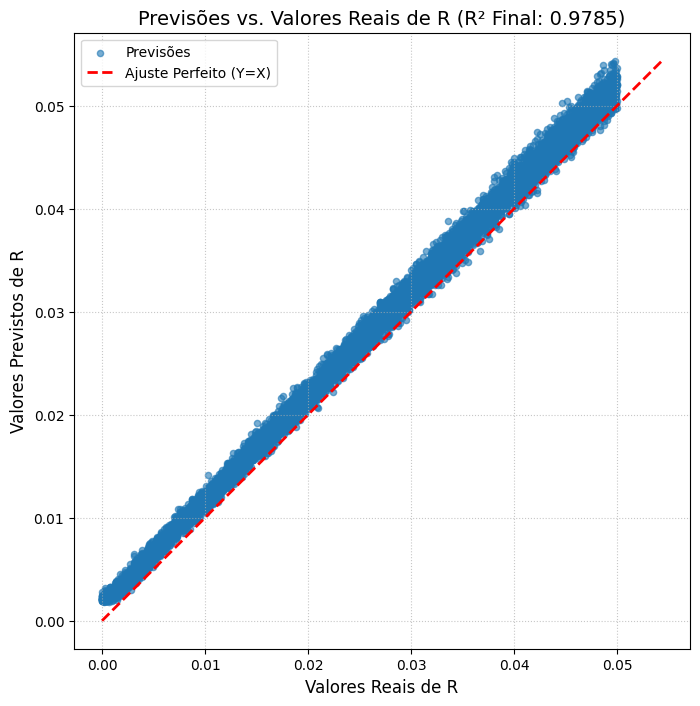

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Suponha que você já tem:
# y_true_original: valores verdadeiros de 'r' (na escala original)
# y_pred_original: valores previstos de 'r' (na escala original)

# Crie a linha de identidade X=Y
min_val = min(y_train.min(), y_pred.min())
max_val = max(y_train.max(), y_pred.max())
ideal_line = np.linspace(min_val, max_val, 100)

plt.figure(figsize=(8, 8))

# 1. Scatter Plot dos Resultados
plt.scatter(y_train, y_pred, alpha=0.6, s=20, label='Previsões')

# 2. Linha de Identidade (Ajuste Perfeito)
plt.plot(ideal_line, ideal_line, color='red', linestyle='--', linewidth=2, label='Ajuste Perfeito (Y=X)')

plt.title(f'Previsões vs. Valores Reais de R (R² Final: {final_r2:.4f})', fontsize=14)
plt.xlabel('Valores Reais de R', fontsize=12)
plt.ylabel('Valores Previstos de R', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.gca().set_aspect('equal', adjustable='box') # Garante que os eixos tenham a mesma escala
plt.show()

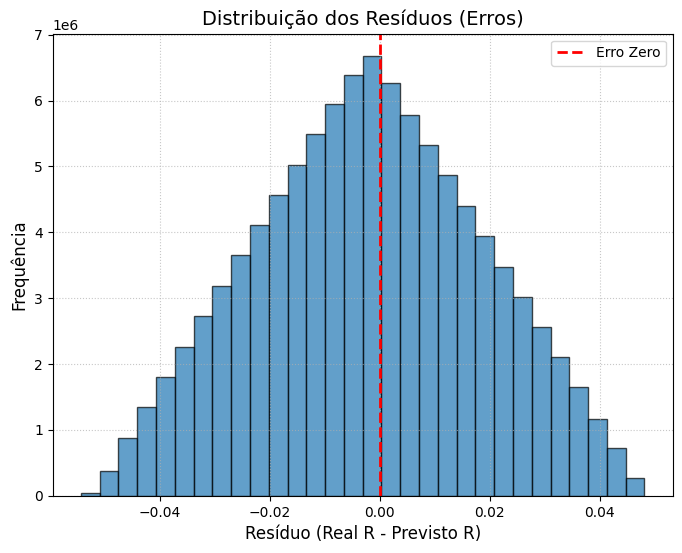

In [20]:
# Calcule os resíduos (True - Predicted)
residuals = y_true - y_pred

# Achata o array para 1D (o formato (N,))
residuals_1d = residuals.ravel()

plt.figure(figsize=(8, 6))

# Histograma dos resíduos
plt.hist(residuals_1d, bins=30, edgecolor='black', alpha=0.7)

# Linha vertical em zero (onde o centro do histograma deveria estar)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Erro Zero')

plt.title('Distribuição dos Resíduos (Erros)', fontsize=14)
plt.xlabel('Resíduo (Real R - Previsto R)', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()